# Изучаем приложение по продаже продуктов питания

**Содержание**

<a id=0> </a>
[Введение](#1)  
[Предобработка](#2)  
[Изучение и проверка данных](#3)  
[Воронка событий](#4)  
[Результаты теста](#5)  
[Вывод](#6)



<a id=1> </a>
## Введение

Наш стартап занимается продажей продуктов питания. Дизайнеры предложить поменять шрифты во всем приложении, но поскольку не было уверенности в том, что это положительно повлияет на бизнес-метрики нашей компании, мы приняли решение провести небольшое (по времени) A/B-тестирование. Нам важно было понять, как ведут себя пользователи приложения и на каких шагах возникают трудности.  
Мы провели А/А/В-тестирование: пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. то есть у нас было 2 контрольные группы, что имеет преимущества, т.к. мы можем проверить есть ли разница между двемя контрольными группами и таким образом понять, правильно ли мы произвели разделение пользователей на группы и как следствие - можем ли мы доверять результатам исследования.

У нас уже есть его резуьтаты, в данном исследовании мы изучим их, построим воронку продаж и решим, стоит ли менять дизайн сайта.

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
import numpy as np
import math as mth

In [2]:
# загрузим датасет
try: 
    data = pd.read_csv('/Users/09e6y/Desktop/Катькис/Практикум/Проект 9 Второй сборный/logs_exp.csv', sep='\t')
except FileNotFoundError:
    data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [4]:
data.columns=('event_name', 'user_id', 'event_time', 'group') # переименуем столбцы
data.head()

,event_name,user_id,event_time,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<a id=2> </a>
## Предобработка

Проверим на наличие ошибок и дубликатов.

In [5]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   user_id     244126 non-null  int64 
 2   event_time  244126 non-null  int64 
 3   group       244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [6]:
data.duplicated().sum() # посчитаем дубликаты

413

In [7]:
data = data.drop_duplicates().reset_index(drop=True) # удалим дубликаты
data.duplicated().sum()

0

Пропусков нет, все типы данных соответствуют заявленным.

Добавим столбец даты-времени и отдельный - только с датой.

In [8]:
data['date_time'] = pd.to_datetime(data['event_time'], unit='s')
data['date'] = data['date_time'].dt.date
data


,event_name,user_id,event_time,group,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
243709,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
243710,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
243711,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


[Содержание](#0)

<a id=3> </a>
## Изучение и проверка данных

### Сколько всего событий в логе? 

In [9]:
print('В логе', data['event_name'].count(), 'события')


В логе 243713 события


### Сколько всего пользователей в логе?

In [10]:
print('В логе', data['user_id'].nunique(), 'пользователь')

В логе 7551 пользователь


### Сколько в среднем событий приходится на пользователя?

In [11]:
# посчитаем количество событий на пользователя и возьмем среднее
event_mean = data.groupby('user_id', as_index=False).agg({'event_name': 'count'})
print('В среднем на пользователя приходится', round(event_mean['event_name'].mean(), 1), 'события')

В среднем на пользователя приходится 32.3 события


Посмотрим, есть ли выбросы в наших даннах

In [12]:
event_mean

,user_id,event_name
0,6888746892508752,1
1,6909561520679493,5
2,6922444491712477,47
3,7435777799948366,6
4,7702139951469979,137
...,...,...
7546,9217594193087726423,9
7547,9219463515465815368,17
7548,9220879493065341500,7
7549,9221926045299980007,7


In [13]:
event_mean.describe()

,user_id,event_name
count,7.551000e+03,7551.000000
mean,4.677319e+18,32.275593
std,2.655343e+18,65.154219
min,6.888747e+15,1.000000
25%,2.397700e+18,9.000000
50%,4.688022e+18,20.000000
75%,7.007353e+18,37.000000
max,9.222603e+18,2307.000000


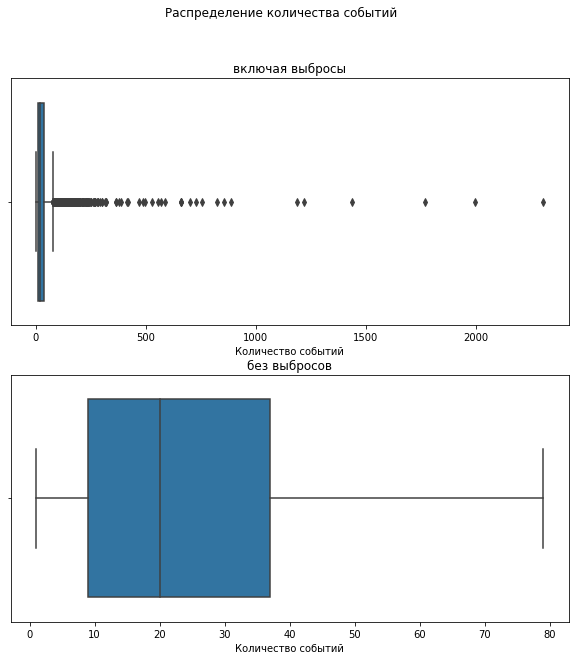

In [14]:
fig, ax = plt.subplots(2,1, figsize=(10, 10)) # нарисуем фигуру из 2 сабплотов
fig.suptitle('Распределение количества событий')

# в первую область положим данные, включающие выбросы
sns.boxplot(ax=ax[0], data = event_mean, x = 'event_name') 
ax[0].set_title('включая выбросы')
ax[0].set_xlabel('Количество событий')

# из второй области выбросы исключим
ax[1].set_title('без выбросов')
sns.boxplot(ax=ax[1], data = event_mean, x = 'event_name',  showfliers=False) 
ax[1].set_xlabel('Количество событий');

Посмотрим так же какой процент данных - выборосы.

In [15]:
print(np.percentile(event_mean['event_name'], [95, 99]))

[ 89.  200.5]


Процент выбросов не такой уж и большой - не более 5% пользователей совершили более 89 действий. Проверим, сколько данных мы потеряем, если исключим их.

In [16]:
# сначала отсечем из таблицы всех лишних юзеров
event_mean = event_mean.query('event_name <= 89')
# соберем уникальные id в список
id_list = event_mean['user_id'].unique()
# отфильтруем датасет по этим id
data_filtred = data[data['user_id'].isin(id_list)]
display(data.shape)
data_filtred.count()/data.count()*100

(243713, 6)

event_name    70.878862
user_id       70.878862
event_time    70.878862
group         70.878862
date_time     70.878862
date          70.878862
dtype: float64

При такой обработке мы потеряем около 30% пользователей, а это не очень хорошо. Поэтому лучше спросим о выбросах коллег, отвечающих за сбор данных.

In [17]:
# сделаем проверку
event_mean = data.groupby('user_id', as_index=False).agg({'event_name': 'count'})
event_mean.describe()

,user_id,event_name
count,7.551000e+03,7551.000000
mean,4.677319e+18,32.275593
std,2.655343e+18,65.154219
min,6.888747e+15,1.000000
25%,2.397700e+18,9.000000
50%,4.688022e+18,20.000000
75%,7.007353e+18,37.000000
max,9.222603e+18,2307.000000


В среднем на пользователя приходится 32,2% событий, но медианное значение всего 20.

### Какой период времени содержится в наших данных?

In [18]:
display(data['date_time'].min()) # минимальная дата
data['date_time'].max() # максимальная дата

Timestamp('2019-07-25 04:43:36')

Timestamp('2019-08-07 21:15:17')

В нашем датасете данные с 25 июля по 7 августа 2019 года.

Изучим пользовательскую активность за весь период.

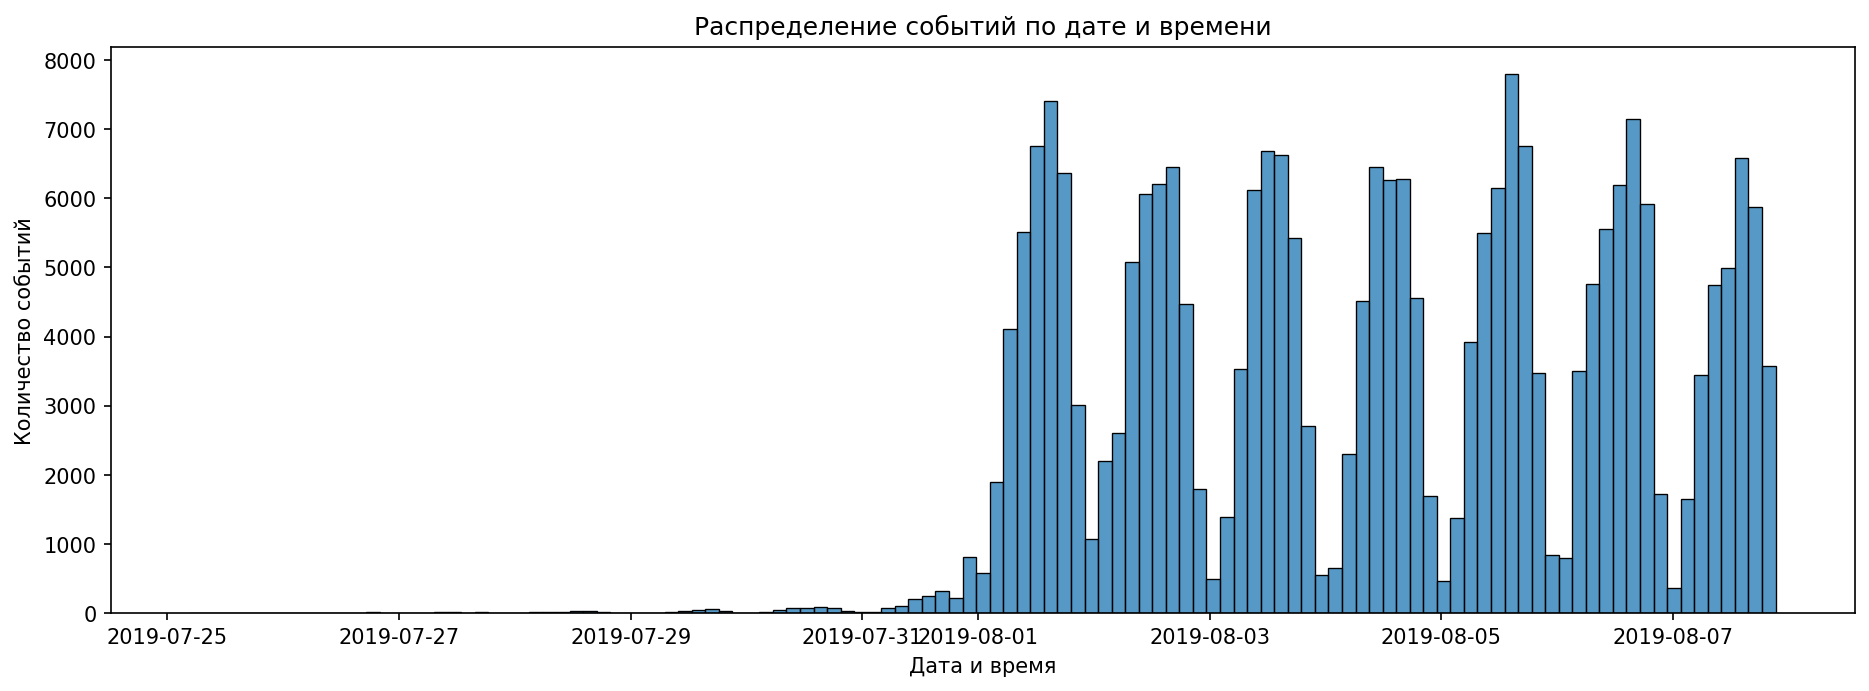

In [19]:
# построим гистограмму распределения событий по дням
fig, ax=plt.subplots(figsize=(15, 5), dpi=150)
ax=sns.histplot(data=data, x='date_time')
plt.title('Распределение событий по дате и времени')
plt.xlabel('Дата и время')
plt.ylabel('Количество событий');

Кажется до 1 августа вообще никакой антивности не было, но поскольку данные могут "доехать", мы сделаем срез с 5 утра 1.08.  
Так же отметим, пики, выглядящие как нормальное распределение - бОльшая активность приходится на дневные часы. То есть по факту мы располагаем данными лишь за одну неделю августа с 1 по 7 число.

Посмотрим, сколько событий мы отбросим.

In [20]:
# посчитаем количество событий в срезе до 1 августа
data_exclude = data.query('date_time < "2019-08-01 00:00:00"')['date_time'].count()
# всего событий в датасете
all_event = data['date_time'].count()
print('Отбрасываем', round(data_exclude/all_event*100, 1), '% событий')


Отбрасываем 1.2 % событий


In [21]:
# посчитаем пользователей в изначальном датасете
data_users = data.groupby('user_id')['user_id'].nunique().count()
data = data[data['date_time'] >= '2019-08-01 00:00:00'] # сделаем срез
# снова посчитаем пользователей
data_users_new = data.groupby('user_id')['user_id'].nunique().count()
lost_users = data_users - data_users_new
print('Мы потеряем', lost_users, 'уникальных пользователей')


Мы потеряем 17 уникальных пользователей


### Проверим наличие пользователей из всех трех групп

In [22]:
groups = data.groupby('group')['event_time'].count()
groups


group
246    79302
247    77022
248    84563
Name: event_time, dtype: int64

У нас есть данные из 3 групп, которые приблизительно равны.

Мы очистили данные от выбросов, узнали что в среднем каждый пользователь совершил 32.2 события, посчитали сколько пользователей в наших данных и уточнили все ли группы на месте. Так же мы узнали тестируемый период времени: 1-7 августа 2019.

[Содержание](#0)

<a id=4> </a>
## Воронка событий

Для начала разберемся, какие вообще события есть в наших данных, какова их частота и последовательность.

Посмотрим, сколько пользователей совершили каждое из событий.


In [23]:
# сгруппируем по названию события
event = data.groupby('event_name')\
    .agg({'date_time' : 'count'})\
    .sort_values(by='date_time', ascending=False)\
    .reset_index() # перезагрузим индексы
event.columns=('event_name', 'event_fr') # переименуем колонки
event


,event_name,event_fr
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Чаще всего пользователи просматривали главный экран, а реже всего - выполняли Туториал. Все ожидаемо.

Отсортируем события по числу пользователей. Посчитаем долю пользователей, с которыми хоть раз произошло данное событие.

In [24]:
# сгруппируем по кникальным пользователям
event_user = data.groupby('event_name', as_index=False)['user_id'].nunique().sort_values(by='user_id', ascending=False).reset_index(drop=True)
all_users = data['user_id'].nunique()
event_user['rate'] = event_user['user_id']
event_user['rate'] = event_user['rate'].shift(periods=1, fill_value=7408) # сдвинем колонку на 1, чтобы потом построчно получить долю
event_user = event_user.drop(labels=[4], axis=0,)
event_user['rate'] = round(event_user['user_id']/event_user['rate']*100)
event_user.columns = ('event_name', 'sum_users', 'rate')
# добавим колонку с долей от общего числа пользователей
event_user['total_rate'] = round(event_user['sum_users']/all_users*100)
event_user

,event_name,sum_users,rate,total_rate
0,MainScreenAppear,7419,100.0,98.0
1,OffersScreenAppear,4593,62.0,61.0
2,CartScreenAppear,3734,81.0,50.0
3,PaymentScreenSuccessful,3539,95.0,47.0


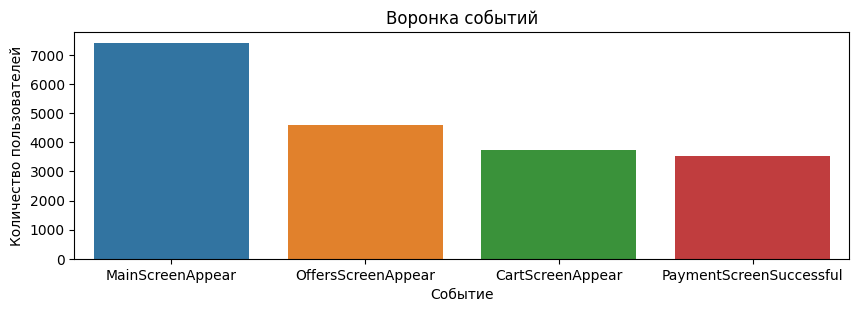

In [25]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=100)
ax = sns.barplot(data=event_user, x='event_name', y='sum_users')
plt.title('Воронка событий')
plt.xlabel('Событие')
plt.ylabel('Количество пользователей');

Мы получили воронку событий. Туториал из нее можно выбросить - он не обязательный и не влияет на последовательность.

Больше всего теряется между первым и вторым шагом. Посмотрим какой процент доходит до оплаты.

In [26]:
print('От начала и до конца всю воронку проходит', round(event_user['sum_users'][3]/event_user['sum_users'][0]*100), '% пользователей')


От начала и до конца всю воронку проходит 48 % пользователей


Наша конверсия в покупку - 48%

[Содержание](#0)

<a id=5> </a>
## Результаты А/В-теста 
(который на самом деле А/А/В-тест)

Выше мы уже узнали, сколько участников в каждой из групп:

In [27]:
groups

group
246    79302
247    77022
248    84563
Name: event_time, dtype: int64

Посмотрим так же, нет ли в наших данных пользователей, которые входили бы сразу в несколько групп.

In [28]:
data.head()


,event_name,user_id,event_time,group,date_time,date
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [29]:
data_group = data.groupby('user_id', as_index=False).agg({'group': 'nunique'})

data_group.query('group > 1')


,user_id,group


По формальному признаку группы разбиты правильно - нет ползователей, которые бы случайно попали в несколько групп сразу.

### Проверяем статистическую разницу между группами

Группы 246 и 247 - контрольные. Давайте проверим, есть ли статистически значимая разница между этими группами.

$H^0$ гипотеза - конверсия групп 246 и 247 не отличается, тогда $H^1$ гипотеза - конверсия групп 246 и 247 отличается статистически значимо. Для этого посмотрим сколько человек из каждой группы совершили каждое из событий.

In [30]:
data.head()

,event_name,user_id,event_time,group,date_time,date
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [31]:
all_groups = data.pivot_table(index = 'event_name', columns='group', values='user_id', aggfunc=lambda x: len(x.unique()))\
    .reset_index()\
    .sort_values(by=246, ascending=False)\
    .reset_index(drop=True)
all_groups = all_groups.drop(labels=[4], axis=0,) # удалим туториал
all_groups

group,event_name,246,247,248
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


Посчитаем так же сколько всего было пользователей в каждой из групп. Это будет 100% 

In [32]:
user_groups = pd.pivot_table(data, index='group', values='user_id', aggfunc=lambda x: len(x.unique())).reset_index()
user_groups


,group,user_id
0,246,2484
1,247,2513
2,248,2537


Добравим первой строкой общее число пользователей из каждой группы, участвовавших в эксперименте.

In [33]:
# создадим строку с пользователями
new_row = pd.DataFrame({'event_name' : ['AllUsers'], 246: [user_groups['user_id'][0]], 247: [user_groups['user_id'][1]], 248: [user_groups['user_id'][2]]})
# соединим два датафрейма
all_groups = pd.concat([new_row, all_groups], ignore_index = True, axis = 0)
all_groups


,event_name,246,247,248
0,AllUsers,2484,2513,2537
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,CartScreenAppear,1266,1238,1230
4,PaymentScreenSuccessful,1200,1158,1181


Посмотрим, какая доля пользователей из группы совершила это действие.

In [34]:
print('Доля пользователей из группы 246, увидевшая главный экран =', round(all_groups[246][1]/all_groups[246][0]*100, 1), '%')
print('Доля пользователей из группы 247, увидевшая главный экран =', round(all_groups[247][1]/all_groups[247][0]*100, 1), '%')


Доля пользователей из группы 246, увидевшая главный экран = 98.6 %
Доля пользователей из группы 247, увидевшая главный экран = 98.5 %


Интересно, какое же событие произошло с этими пользователями, если они получили номер участия, но даже не посмотрели на главную страницу?

Главным по популярности тем не менее становится просмотр главной страницы. Проверим разницу конверсии в группах.  
$H^0$ и $H^1$ останутся теми же.

In [35]:
# напишем функцию, которая будет проверять равернство групп

def equal(successes, trials):
    alpha = .05 # критический уровень статистической значимости
  
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.')
        
# применим нашу функцию, чтобы сравнить группы
 
successes = np.array([all_groups[246][1], all_groups[247][1]])
trials = np.array([all_groups[246][0], all_groups[247][0]])
equal(successes, trials)


p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


Проверим так же все остальные события для наших контрольных групп

Является ли разница между группами статистически значимой?   
$H^0$ и $H^1$ останутся теми же.

In [36]:
 # напишем цикл, который переберет все пары в таблице ири помощи той же функции
indexes=( 1, 2, 3, 4)

for i in indexes:
    try:
        print(all_groups['event_name'][i])
        equal(np.array([all_groups[246][i], all_groups[247][i]]), np.array([all_groups[246][0], all_groups[247][0]]))
        
    except:
        print() 


MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


Ни в одном из экспериментов конверсия статистически не отличается.

Можно сделать вывод, что разбиение на группы работает корректно.

### Проверяем статистическую разницу контрольных групп с экспериментальной

In [37]:
all_groups


,event_name,246,247,248
0,AllUsers,2484,2513,2537
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,CartScreenAppear,1266,1238,1230
4,PaymentScreenSuccessful,1200,1158,1181


Применим нашу же функцию, только теперь сравнивать будем результаты контрольной группы - с экспериментальной.  
$H^0$ - результаты контрольной группы 246 и экспериментальной 248 не отличаются  
$H^1$ - результаты групп разные.

In [38]:
indexes=(1, 2, 3, 4)
for i in indexes:
    try:
        print(all_groups['event_name'][i])
        equal(np.array([all_groups[246][i], all_groups[248][i]]), np.array([all_groups[246][0], all_groups[248][0]]))
    except:
        print()

MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


Кажется контрольная группа не показала результата, конверсия не поменялась статистически значимо. Посмотрим на результаты второй контрольной группы.  
$H^0$ - результаты контрольной группы 247 и экспериментальной 248 не отличаются  
$H^1$ - результаты групп разные.

In [39]:

for i in indexes:
    try:
        print(all_groups['event_name'][i])
        equal(np.array([all_groups[247][i], all_groups[248][i]]), np.array([all_groups[247][0], all_groups[248][0]]))
    except:
        print()

MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [40]:
cr247 = round(all_groups[247][4]/all_groups[247][0]* 100, 1)
print('Конверсия в группе 247 составляет',cr247 , '%' )


Конверсия в группе 247 составляет 46.1 %


In [41]:
cr247 = round(all_groups[248][4]/all_groups[248][0]* 100, 1)
print('Конверсия в группе 248 составляет',cr247 , '%' )


Конверсия в группе 248 составляет 46.6 %


И по-прежнему эксперимент не дает надежного результата, позволяющего судить о том, что смена шрифта приводит к повышению конверсии на каком-либо этапе. Мы так же видим, что конверсия в группах 247 и 248 отличается лишь на 5/10%.

Попробуем объединить контрольные группы и сделать сравнение с экспериментальной еще раз.

In [42]:
all_groups['246-247'] = all_groups[246]+all_groups[247]
all_groups


,event_name,246,247,248,246-247
0,AllUsers,2484,2513,2537,4997
1,MainScreenAppear,2450,2476,2493,4926
2,OffersScreenAppear,1542,1520,1531,3062
3,CartScreenAppear,1266,1238,1230,2504
4,PaymentScreenSuccessful,1200,1158,1181,2358


In [43]:
for i in indexes:
    try:
        print(all_groups['event_name'][i])
        equal(np.array([all_groups['246-247'][i], all_groups[248][i]]), np.array([all_groups['246-247'][0], all_groups[248][0]]))
    except:
        print()

MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


В общем картина не поменялась, между контрольной и экспериментальной группой все так же нет значимой разницы в отношении конверсии.

[Содержание](#0)


## Можно ли доверять результатам эксперимента?

Мы выбрали уровень статистической значимости 0.05 - это значит что каждый 20 эксперимент может дать ложный результат. В ходе исследования мы проделали 16 экспериментов, это означает, что выбранный нами уровень статистической значимости позволяет доверять результатам.

<a id=6> </a>
## Вывод

В нашем исследовании мы хотели проверить, повлияет ли изменение шрифта на поведение пользователей при помощи результатов A/B-тестирования.  
Мы располагаем данными за 1 неделю: с 1 по 7 августа.  
Мы проверили данные на наличие ошибок, убедились что разбиение на группы совершено корректно и ни один пользователей не попал случайно более, чем в 1 группу.  
Воронка событий показала что больше всего пользователей отпадает после просмотра главного экрана. Конверсия пользователей в покупку составляет 48%.
Далее мы сравнили результаты пользователей из двух контрольных групп между собой и, сравнив конверсию, убедились что между ними нет статистически значимой разницы. Но мы так же и не нашли значимой разницы между контрольными и экспериментальной группой.

По результатам исследования, следует сделать вывод что смена шрифта никак не повлияла на поведение пользователей, поэтому не является целесообразным тратить средства на то, чтобы вводить какие-либо изменения на сайте.
